# WaterLevel with Deep Sleep v1 


In [1]:
from collections import defaultdict
import json
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture

In [2]:
experiment = "waterlevel2"
power_profiler_freq = 10 #ms
board="nodemcu"
r = 0 #s run time (0 => no deep sleep)
ds = 0 #s deep_sleep time (0 => no deep sleep)
update_interval = 1000 #ms
test_num = 1 #test_number

#Analisys
batteries = [0.8, 2, 4, 10] #Ah
deep_sleep_times = [0, 10, 30, 60, 600, 1800, 3600]

## Code

In [3]:
def load_data(filename, show=False):
    try:
        df = pd.read_csv(filename)
        if show:
            display(df.head())
    except FileNotFoundError:
        print(f"Error: '{fn}' not found.")
    except pd.errors.ParserError:
        print("Error: Unable to parse the CSV file. Check the file format.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
    return df

In [4]:
def preprocess(df): 
    '''
    Check for missing values
    '''
    missing_values = df['current'].isnull().sum()
    missing_percentage = (missing_values / len(df['current'])) * 100
    print(f"Missing values in 'current' column: {missing_values} ({missing_percentage:.2f}%)")

    # Determine data type and convert if necessary
    print(f"Original data type of 'current' column: {df['current'].dtype}")
    if not pd.api.types.is_numeric_dtype(df['current']):
        try:
            df['current'] = pd.to_numeric(df['current'], errors='coerce')
            print("Converted 'current' column to numeric type.")
        except Exception as e:
            print(f"Error converting 'current' column: {e}")
    print(f"Data type of 'current' column after conversion: {df['current'].dtype}")

    # Calculate descriptive statistics
    descriptive_stats = df['current'].describe()
    print("\nDescriptive Statistics for 'current' column:")
    print(descriptive_stats)
    return df

**Reasoning**:
Clean the 'current' column by removing outliers using the IQR method and impute any remaining missing values with the median.


**NOTA: ALGO SE VE RARO EN ESTO, REVISAR EL MÉTODO, PUEDE SER QUE NO ELIMINE NADA **

In [5]:
def clean(df):
    quantile_low = 0.25
    quantile_high = 0.75
    iqr_factor = 1.5

    # Calculate Q1, Q3, and IQR
    Q1 = df['current'].quantile(quantile_low)
    Q3 = df['current'].quantile(quantile_high)
    IQR = Q3 - Q1

    # Define bounds for outlier removal
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    print(f"IQR lower_bound: {lower_bound}, upper_bound: {upper_bound})")

    # Remove outliers
    org_len = len(df['current'])
    df = df[~((df['current'] < lower_bound) | (df['current'] > upper_bound))]
    removed_len = len(df['current'])
    print(f"Length before IQR bounds: {org_len}, after: {removed_len}")

    # Display descriptive statistics after outlier removal
    print("\nDescriptive Statistics for 'current' column after outlier removal:")
    print(df['current'].describe())

    # Handle any remaining missing values
    if df['current'].isnull().any():
        median_current = df['current'].median()
        df['current'].fillna(median_current, inplace=True)
        print("\nDescriptive Statistics for 'current' column after imputation:")
        print(df['current'].describe())
    else:
        print("\nNo missing values found after outlier removal.")
    return df

In [6]:
def gmm_fit(data, plot_results=False):
    """
    Finds a current threshold to separate high and low current usage modes using Gaussian Mixture Models.

    Args:
        data (pd.Series or np.array): The current usage data.
        plot_results (bool, optional): Whether to plot the histogram and GMM fit. Defaults to False.

    Returns:
        float: The current threshold separating the modes, or None if the fitting fails.
        array of means
        array of labels
    """

    if isinstance(data, pd.Series):
        data = data.values.reshape(-1, 1) #Reshape for sklearn
    elif isinstance(data, np.ndarray):
        data = data.reshape(-1, 1)
    else:
        raise TypeError("Input data must be a pandas Series or numpy array.")

    try:
        gmm = GaussianMixture(n_components=2)
        labels = gmm.fit_predict(data)
        means = gmm.means_.flatten()
        means.sort()  # Ensure means are sorted: low, high

        # Calculate the threshold as the midpoint between the means
        threshold = (means[0] + means[1]) / 2

        if plot_results:
            plt.hist(data, bins=50, density=True, alpha=0.6, color='g')
            x = np.linspace(data.min(), data.max(), 200).reshape(-1, 1)
            logprob = gmm.score_samples(x)
            pdf = np.exp(logprob)
            plt.plot(x, pdf, '-r')
            plt.axvline(threshold, color='b', linestyle='--', label=f'Threshold: {threshold:.4f}')
            plt.axvline(means[0], color="#888888", linestyle="--", label=f"Mean 0: {means[0]:.4f}")
            plt.axvline(means[1], color="#888888", linestyle="--", label=f"Mean 1: {means[1]:.4f}")
            plt.legend()
            plt.xlabel("Current")
            plt.ylabel("Density")
            plt.title("Current Usage Distribution and GMM Fit")
            plt.show()

        return threshold, means, labels

    except Exception as e:
        print(f"Error during GMM fitting: {e}")
        return None

#Example Usage
# Create a sample dataset (replace with your actual data)

In [7]:
def analyze_cycles(df):
    """
    Analyzes and separates high current usage cycles and deep sleep periods.
    """
    
    cycles = []
    # Iterate over the DataFrame and check for transitions between high and low current states.
    # This is a simplified representation, and the logic may need adjustment based on your specific requirements
    current_state = None
    start_time = None
    for index, row in df.iterrows():
        if row['state_label'] == "high":
            if current_state != "high":  # Transition to high current state
                if current_state == "low":
                    cycles.append({"state":"low", "start_time":start_time, "end_time": row['read_at']})
                current_state = "high"
                start_time = row['read_at']
        else:
            if current_state != "low":  # Transition to low current state
                if current_state == "high":
                    cycles.append({"state":"high", "start_time":start_time, "end_time": row['read_at']})
                current_state = "low"
                start_time = row['read_at']

    # Handle the last cycle
    if start_time:
        cycles.append({"state":current_state, "start_time":start_time, "end_time": df['read_at'].iloc[-1]})

    return cycles

## Analysis

In [8]:
experiment_name = f"{board}_up{update_interval}_r{r}_ds{ds}-t{test_num}"
filename = f"../data/{experiment}-f{power_profiler_freq}--{experiment_name}.csv"
print(experiment_name)
print(filename)
df = load_data(filename, True)

nodemcu_up1000_r0_ds0-t1
../data/waterlevel2-f10--nodemcu_up1000_r0_ds0-t1.csv


,index,read_at,millis,timestamp,voltage,current,power,bus_voltage
0,0,2025-03-12 18:33:12.879518,303431,2025-03-12 18:33:12,5.064,0.0836,0.42335,0.00836
1,1,2025-03-12 18:33:12.880387,303443,2025-03-12 18:33:12,5.064,0.0836,0.42335,0.00836
2,2,2025-03-12 18:33:12.881059,303453,2025-03-12 18:33:12,5.064,0.0820,0.41525,0.00820
3,3,2025-03-12 18:33:12.881679,303464,2025-03-12 18:33:12,5.064,0.0820,0.41525,0.00820
4,4,2025-03-12 18:33:12.882343,303475,2025-03-12 18:33:12,5.064,0.0832,0.42132,0.00832


Descriptive Statistics for 'current' column:
count    5276.000000
mean        0.083276
std         0.001987
min         0.080000
25%         0.082800
50%         0.083200
75%         0.083200
max         0.123200
Name: current, dtype: float64


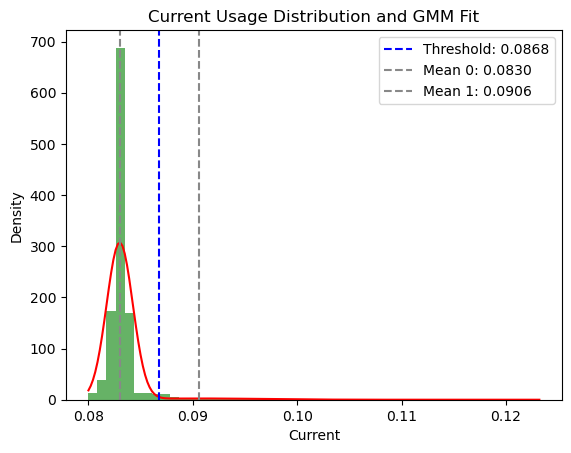

In [9]:
# Convert 'read_at' to datetime objects
df['read_at'] = pd.to_datetime(df['read_at'])

# Calculate descriptive statistics
descriptive_stats = df['current'].describe()
print("Descriptive Statistics for 'current' column:")
print(descriptive_stats)

# Analyze trends using rolling mean
df['rolling_mean'] = df['current'].rolling(window=5, center=False).mean()

threshold, means, labels = gmm_fit(df.current, plot_results=True)

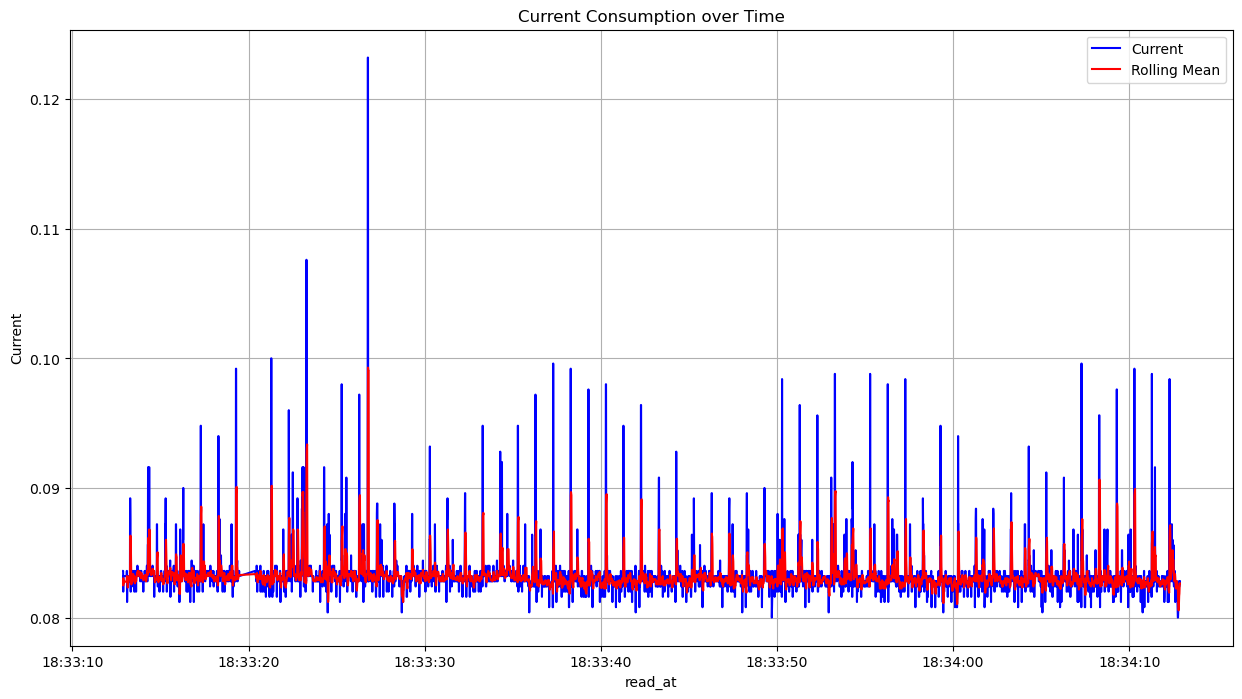

In [10]:
# Visualize trends and anomalies
plt.figure(figsize=(15, 8))
plt.plot(df['read_at'], df['current'], label='Current', color='blue')
plt.plot(df['read_at'], df['rolling_mean'], label='Rolling Mean', color='red')

plt.xlabel('read_at')
plt.ylabel('Current')
plt.title('Current Consumption over Time')
plt.legend()
plt.grid(True)
plt.show()

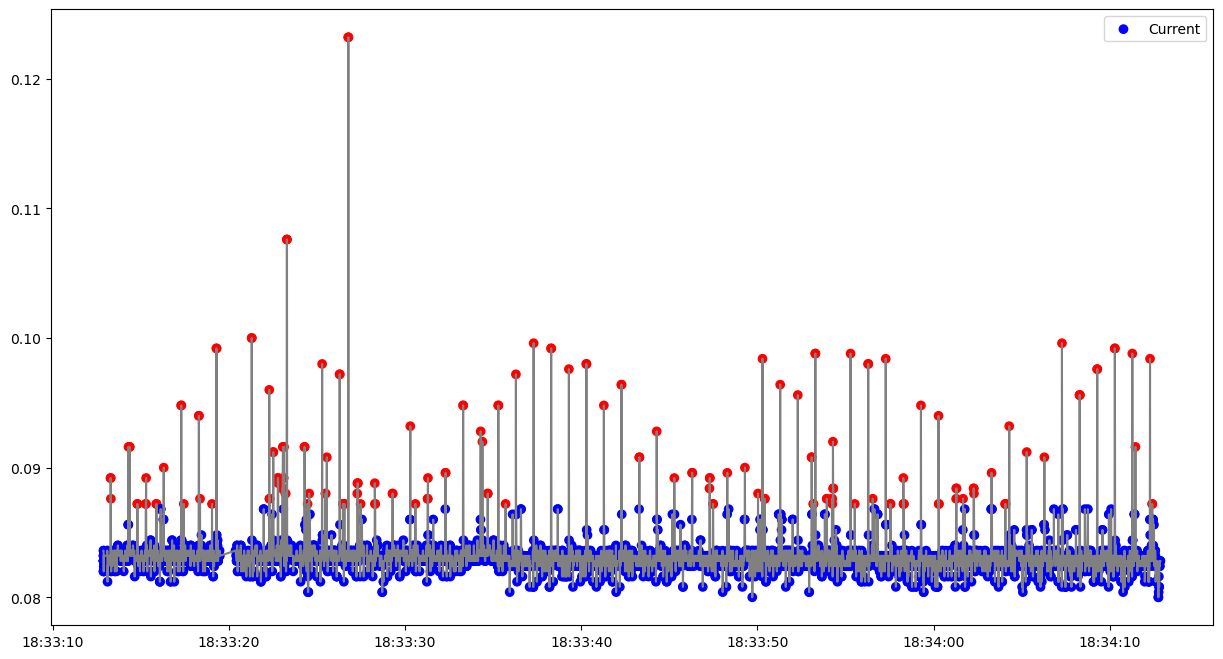

In [11]:
plt.figure(figsize=(15, 8))
plt.plot(df['read_at'], df['current'], color="gray")
plt.scatter(df['read_at'], df['current'], label='Current', c=labels, cmap=ListedColormap(["blue", "red"]))
#plt.axhline(threshold, color='b', linestyle='--', label=f"threshold={threshold:.4f}")
plt.legend()

In [12]:
states = ["low", "high"]
if means[0] > means[1]:
    states = ["high", "low"]
df['state_label'] = [states[l] for l in labels]

In [13]:
for index, state in zip([0, 1], states):
    print(f"Average current in {state}: {means[index]}")

Average current in low: 0.0829941175272336
Average current in high: 0.09060961868011941


In [14]:

cycles = analyze_cycles(df)

# Example calculations for each cycle
durations = defaultdict(list)
#Excluir la primera y ultima fases capturadas porque estan incompletas
print("State\tStart\tEnd\tDuration")
for cycle in cycles[1:-1]:
    duration = cycle['end_time'] - cycle['start_time']
    durations[cycle['state']].append(duration.total_seconds())
    print(f"{cycle['state']}\t{cycle['start_time']}\t{cycle['end_time']}\t{duration}")
    # Add other calculations as needed (e.g., average current within the cycle, energy consumption)

average_durations = {state: (sum(d) / len(d)) for state, d in durations.items()}
print(f"Average durations: {average_durations}")

State	Start	End	Duration
high	2025-03-12 18:33:13.275621	2025-03-12 18:33:13.305584	0 days 00:00:00.029963
low	2025-03-12 18:33:13.305584	2025-03-12 18:33:14.295665	0 days 00:00:00.990081
high	2025-03-12 18:33:14.295665	2025-03-12 18:33:14.306555	0 days 00:00:00.010890
low	2025-03-12 18:33:14.306555	2025-03-12 18:33:14.355699	0 days 00:00:00.049144
high	2025-03-12 18:33:14.355699	2025-03-12 18:33:14.375674	0 days 00:00:00.019975
low	2025-03-12 18:33:14.375674	2025-03-12 18:33:14.795674	0 days 00:00:00.420000
high	2025-03-12 18:33:14.795674	2025-03-12 18:33:14.815686	0 days 00:00:00.020012
low	2025-03-12 18:33:14.815686	2025-03-12 18:33:15.275636	0 days 00:00:00.459950
high	2025-03-12 18:33:15.275636	2025-03-12 18:33:15.305661	0 days 00:00:00.030025
low	2025-03-12 18:33:15.305661	2025-03-12 18:33:15.875604	0 days 00:00:00.569943
high	2025-03-12 18:33:15.875604	2025-03-12 18:33:15.895669	0 days 00:00:00.020065
low	2025-03-12 18:33:15.895669	2025-03-12 18:33:16.295635	0 days 00:00:00.3999

In [15]:
for cycle in cycles[1:-1]:
    # Filter the DataFrame to include only data points within the current cycle
    cycle_data = df[(df['read_at'] >= cycle['start_time']) & (df['read_at'] <= cycle['end_time'])]

    # Calculate the average current for the current cycle
    avg_current = cycle_data['current'].mean()

    # Print the average current for the current cycle
    print(f"Average Current for Cycle ({cycle['state']}): {avg_current:.4f} A")


Average Current for Cycle (high): 0.0870 A
Average Current for Cycle (low): 0.0833 A
Average Current for Cycle (high): 0.0878 A
Average Current for Cycle (low): 0.0851 A
Average Current for Cycle (high): 0.0888 A
Average Current for Cycle (low): 0.0834 A
Average Current for Cycle (high): 0.0860 A
Average Current for Cycle (low): 0.0831 A
Average Current for Cycle (high): 0.0867 A
Average Current for Cycle (low): 0.0833 A
Average Current for Cycle (high): 0.0859 A
Average Current for Cycle (low): 0.0834 A
Average Current for Cycle (high): 0.0866 A
Average Current for Cycle (low): 0.0832 A
Average Current for Cycle (high): 0.0913 A
Average Current for Cycle (low): 0.0835 A
Average Current for Cycle (high): 0.0854 A
Average Current for Cycle (low): 0.0833 A
Average Current for Cycle (high): 0.0907 A
Average Current for Cycle (low): 0.0843 A
Average Current for Cycle (high): 0.0852 A
Average Current for Cycle (low): 0.0833 A
Average Current for Cycle (high): 0.0854 A
Average Current for Cy

## Battery predictions

### deep sleep as measured by power_profiler

In [16]:
avg_high_current = means[states.index('high')]
avg_low_current = means[states.index('low')]

batteries = [0.8, 2, 4, 10] #Ah
avg_current = avg_high_current * average_durations['high'] + avg_low_current * average_durations['low']
avg_current /= average_durations['high'] + average_durations['low']
print(f"Average current: {avg_current * 1000:.2f} mA")

for bat_usable_cap in batteries: #Amp hour
    runtime = bat_usable_cap / avg_current
    print(f"At {bat_usable_cap:.02f}Ah:\t{runtime:.01f} hours,\t{runtime/24:.02f} days")

Average current: 83.23 mA
At 0.80Ah:	9.6 hours,	0.40 days
At 2.00Ah:	24.0 hours,	1.00 days
At 4.00Ah:	48.1 hours,	2.00 days
At 10.00Ah:	120.1 hours,	5.01 days


### deep sleep current measured by multimeter

In [17]:
boards = json.loads(open("../data/boards.json").read())
boards

{'nodemcu': {'current': {'deep_sleep': 0.0092}},
 'saola': {'current': {'deep_sleep': 0.0009}},
 'wemosd1': {'current': {'deep_sleep': 6.5e-05}},
 'wemosc3mini': {'current': {'deep_sleep': 0.000418}}}

In [18]:
deep_sleep_measured_current = boards[board]["current"]["deep_sleep"]

avg_current = avg_high_current * average_durations['high'] + deep_sleep_measured_current * average_durations['low']
avg_current /= average_durations['high'] + average_durations['low']
print(f"Average current: {avg_current * 1000:.2f} mA")

for bat_usable_cap in batteries: #Amp hour
    runtime = bat_usable_cap / avg_current
    print(f"At {bat_usable_cap:.02f}Ah:\t{runtime:.01f} hours,\t{runtime/24:.02f} days")

Average current: 11.74 mA
At 0.80Ah:	68.1 hours,	2.84 days
At 2.00Ah:	170.3 hours,	7.10 days
At 4.00Ah:	340.6 hours,	14.19 days
At 10.00Ah:	851.6 hours,	35.48 days


### predicitions on measured deep sleep

In [19]:
run_time = average_durations['high']
for deep_sleep_time in deep_sleep_times:
    avg_current = avg_high_current * run_time + deep_sleep_measured_current * deep_sleep_time
    avg_current /= run_time + deep_sleep_time
    print(f"\n{board} run_time: {run_time:.2f} seg, deep_sleep_time: {deep_sleep_time:.2f} seg")
    print(f"  average current: {avg_current * 1000:.4f} mA")

    for bat_usable_cap in batteries: #Amp hour
        bat_runtime = bat_usable_cap / avg_current
        print(f"  At {bat_usable_cap:.02f}Ah:\t{bat_runtime:.01f} hours,\t{bat_runtime/24:.02f} days")


nodemcu run_time: 0.02 seg, deep_sleep_time: 0.00 seg
  average current: 90.6096 mA
  At 0.80Ah:	8.8 hours,	0.37 days
  At 2.00Ah:	22.1 hours,	0.92 days
  At 4.00Ah:	44.1 hours,	1.84 days
  At 10.00Ah:	110.4 hours,	4.60 days

nodemcu run_time: 0.02 seg, deep_sleep_time: 10.00 seg
  average current: 9.3564 mA
  At 0.80Ah:	85.5 hours,	3.56 days
  At 2.00Ah:	213.8 hours,	8.91 days
  At 4.00Ah:	427.5 hours,	17.81 days
  At 10.00Ah:	1068.8 hours,	44.53 days

nodemcu run_time: 0.02 seg, deep_sleep_time: 30.00 seg
  average current: 9.2522 mA
  At 0.80Ah:	86.5 hours,	3.60 days
  At 2.00Ah:	216.2 hours,	9.01 days
  At 4.00Ah:	432.3 hours,	18.01 days
  At 10.00Ah:	1080.8 hours,	45.03 days

nodemcu run_time: 0.02 seg, deep_sleep_time: 60.00 seg
  average current: 9.2261 mA
  At 0.80Ah:	86.7 hours,	3.61 days
  At 2.00Ah:	216.8 hours,	9.03 days
  At 4.00Ah:	433.6 hours,	18.06 days
  At 10.00Ah:	1083.9 hours,	45.16 days

nodemcu run_time: 0.02 seg, deep_sleep_time: 600.00 seg
  average current: 9.